In [127]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [128]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [149]:
#Hyper Parameters
torch.manual_seed(40)
batch_size = 128
EPOCH = 100
lr = 0.05

In [150]:
# Dataset & DataLoader

transform = transforms.Compose(
[
    transforms.ToTensor(),
    transforms.Normalize([0], [1])
])

trainset = torchvision.datasets.MNIST(root = './data', train = True,
                                      download = True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size,
                                          shuffle = True, num_workers=1)

testset = torchvision.datasets.MNIST(root = './data', train = False,
                                     download = True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size,
                                         shuffle = True, num_workers=1)

classes = {'0', '1', '2', '3', '4', '5', '6', '7', '8', '9'}

print(trainset)
print('*'*100)
print(testset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0], std=[1])
           )
****************************************************************************************************
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0], std=[1])
           )


torch.Size([32, 1, 28, 28])


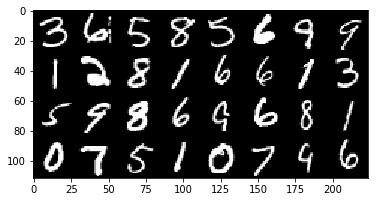

In [151]:
# Visualization Datasets

def show(img):
    print(img.size())
    grid = torchvision.utils.make_grid(img, padding = 0) # make_grid 함수는 3채널로 만든다(모두 같은 format으로)
    tranimg = grid.permute(1,2,0)
    plt.imshow(tranimg)

images, labels = iter(trainloader).next()
show(images[:32])

In [152]:
# Make Model

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 7, padding = 3)
        self.conv2 = nn.Conv2d(10, 50, 7, padding = 3)
        self.conv3 = nn.Conv2d(50, 120, 7, padding = 3)
        self.conv4 = nn.Conv2d(120, 100, 5)
        self.conv5 = nn.Conv2d(100, 20, 5)
        self.conv6 = nn.Conv2d(20, 10, 5)
        self.conv7 = nn.Conv2d(10, 10, 3)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(10 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 360)
        self.fc3 = nn.Linear(360, 50)
        self.fc4 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x)) # 28 28
        x = F.relu(self.conv2(x)) # 28 28
        x = F.relu(self.conv3(x)) # 28 28
        x = F.relu(self.conv4(x)) # 24 24
        x = F.relu(self.conv5(x)) # 20 20
        x = self.pool(F.relu(self.conv6(x))) # 8 8
        x = x.view(-1, 10 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x   

## GPU 사용여부 확인

In [153]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


In [154]:
import torch.optim as optim

model = Net().to(device)

# Weight 초기화
def weight_init(m):
    if ((type(m) == nn.Conv2d) or (type(m) == nn.Linear)):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0)
        
model.apply(weight_init)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 30, gamma = 0.1)
print(loss_func, optimizer)

CrossEntropyLoss() SGD (
Parameter Group 0
    dampening: 0
    initial_lr: 0.05
    lr: 0.05
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [155]:
model.eval()
with torch.no_grad():
    images, labels = next(iter(trainloader))
    images, labels = images.to(device), labels.to(device)
    print(images.size())
    example = model(images)
    print('Test : ', example)
    print(example.size())

torch.Size([128, 1, 28, 28])
Test :  tensor([[-0.0193,  0.0045,  0.0006,  ...,  0.0112,  0.0094,  0.0083],
        [-0.0203,  0.0002, -0.0024,  ...,  0.0093,  0.0032,  0.0108],
        [-0.0258,  0.0123, -0.0033,  ...,  0.0066,  0.0156,  0.0180],
        ...,
        [-0.0244,  0.0127, -0.0071,  ...,  0.0062,  0.0162,  0.0223],
        [-0.0216,  0.0014, -0.0041,  ...,  0.0081,  0.0065,  0.0118],
        [-0.0201,  0.0038,  0.0018,  ...,  0.0047,  0.0115,  0.0104]],
       device='cuda:0')
torch.Size([128, 10])


In [144]:
import time

# Train

model.train()
for e in range(1, EPOCH+1):
    start_time = time.time()
    running_loss = 0
    
    for param_group in optimizer.param_groups:
        learning_rate = param_group['lr']
        
    for i, data in enumerate(trainloader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss
        now = time.time()

        print('\r[%d/%d]-----[%d/%d] LOSS : %.3f------ Time : %d ------- Current lr : %f' 
              %(e, EPOCH, i+1, 60000/batch_size, running_loss, now - start_time, learning_rate), end = '')    
    scheduler.step()        
    print('\n')

[1/100]-----[469/468] LOSS : 494.673------ Time : 16 ------- Current lr : 0.100000

[2/100]-----[469/468] LOSS : 49.258------ Time : 16 ------- Current lr : 0.100000

[3/100]-----[469/468] LOSS : 27.285------ Time : 16 ------- Current lr : 0.100000

[4/100]-----[469/468] LOSS : 20.278------ Time : 16 ------- Current lr : 0.100000

[5/100]-----[469/468] LOSS : 16.011------ Time : 16 ------- Current lr : 0.100000

[6/100]-----[469/468] LOSS : 13.519------ Time : 16 ------- Current lr : 0.100000

[7/100]-----[469/468] LOSS : 11.765------ Time : 16 ------- Current lr : 0.100000

[8/100]-----[469/468] LOSS : 9.600------ Time : 16 ------- Current lr : 0.100000

[9/100]-----[469/468] LOSS : 8.450------ Time : 16 ------- Current lr : 0.100000

[10/100]-----[469/468] LOSS : 7.485------ Time : 16 ------- Current lr : 0.100000

[11/100]-----[469/468] LOSS : 6.457------ Time : 17 ------- Current lr : 0.100000

[12/100]-----[469/468] LOSS : 5.445------ Time : 16 ------- Current lr : 0.100000

[13/1

In [145]:
torch.save(model, 'data/mnist_classifier.pth')
test_model = torch.load('data/mnist_classifier.pth')
test_model

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type MaxPool2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Net(
  (conv1): Conv2d(1, 10, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv2): Conv2d(10, 50, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv3): Conv2d(50, 120, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv4): Conv2d(120, 100, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(100, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv6): Conv2d(20, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv7): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=640, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=360, bias=True)
  (fc3): Linear(in_features=360, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=10, bias=True)
)

torch.Size([8, 1, 28, 28])
GroundTruth :  6 6 7 0 2 1 4 9
Predicted :  0 0 0 0 0 0 0 0


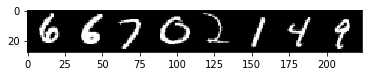

In [146]:
model.eval()
with torch.no_grad():
    classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
    
    test_data = iter(testloader)
    test_images, test_labels = iter(testloader).next()
    show(test_images[:8])
    test_images, test_labels = test_images[:8].to(device), test_labels[:8].to(device)
    
    test_outputs = test_model(test_images)
    predicted = test_outputs.argmax(dim=1)
    
    
    print('GroundTruth : ', ' '.join(classes[test_labels[j]] for j in range(8)))
    print('Predicted : ', ' '.join(classes[predicted[i]] for i in range(8)))


In [147]:
correct = 0
test_loss = 0
model.eval()

with torch.no_grad():
    for data in testloader:
        val_images, val_labels = data
        val_images, val_labels = val_images.to(device), val_labels.to(device)
        
        val_outputs = model(val_images)
        pred = val_outputs.argmax(dim=1, keepdim=True)
        correct += pred.eq(val_labels.view_as(pred)).sum().item()
        
        
print('Accuracy of the network on the 10000 test images : %.3f %%' 
      %(100 * correct / len(testloader.dataset)))

Accuracy of the network on the 10000 test images : 9.800 %
